In [2]:
import torch 
import math
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets
import os
import scipy

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import balanced_accuracy_score

from src.evaluation import load_iccns
from src.utils import set_random_seeds
from hydra import initialize, compose
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from torch.nn import functional as F
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn import svm, tree
from aif360.sklearn.metrics import equal_opportunity_difference

In [3]:
%matplotlib inline

In [3]:
set_random_seeds(65)

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## Experiment 1

In [68]:
def extract_attribute(file, attributes):
    for attr in attributes:
        if attr in file:
            return attr

def box_plot(df, percentage, attribute, values_column, show=True):
    ax = df.boxplot(column = values_column, by = attribute)
    plt.suptitle("")
    ax.set_title("{}% of subjects wearing {}".format(n, attribute.split("_")[-1].lower()))
    ax.set_ylabel("Kantorovich potential")
    
    plt.savefig("../results/Experiment1/{0}/{0}_Boxplot_{1}.png".format(attribute.split("_")[-1], n))
    plt.tight_layout
    if show:
        plt.show()
        
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [69]:
# paths 
attributes = ["Wearing_Necktie", "Eyeglasses", "Wearing_Hat", "Smiling"]

celebA_csv = "../data/celeba/list_attr_celeba.csv"
uniform_csv = "../data/celeba/experiment1_uniform_sample.csv"
biased_csvs = dict()
dataframes = dict()
for attr in attributes:
    biased_csvs[attr] = ["../data/celeba/experiment1_biased_sample_{}_{}.csv".format(attr, n) for n in [10,30,60,90]]
    dataframes[attr] = [pd.read_csv(biased_csvs[attr][i]) for i in range(4)]


In [70]:
df = pd.read_csv(uniform_csv)

for attr in attributes:
    print(attr, len(df[df[attr]==1])/len(df))

Wearing_Necktie 0.072
Eyeglasses 0.06744444444444445
Wearing_Hat 0.04477777777777778
Smiling 0.47355555555555556


In [71]:
unif_df = pd.read_csv(uniform_csv)

In [72]:
wasserstein_df = pd.read_csv("../results/experiment1_wasserstein.tsv", sep= "\t", header=None)
wasserstein_df.columns = ["X", "Y", "wasserstein"]

wasserstein_df["attr"] = wasserstein_df["X"].apply(lambda x: extract_attribute(x, attributes))

wasserstein = {attr: list(reversed(list(wasserstein_df[wasserstein_df["attr"] == attr].wasserstein)))\
               for attr in attributes}

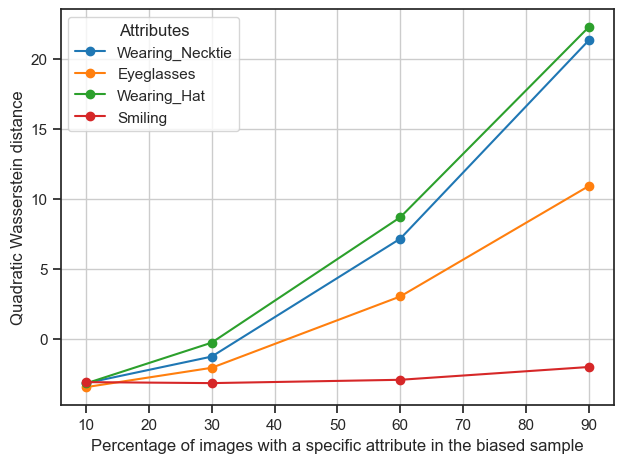

In [73]:
for i, item in enumerate(wasserstein.items()):

    attr, scores = item
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic Wasserstein distance")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Wasserstein_distance_plot.png")
plt.show()

In [74]:
accuracy = dict()
decision_functions = dict()
for attr in attributes:
    accuracy[attr] = dict()
    decision_functions[attr] = dict()
    for j in range(4):
        n = [10,30,60,90][j]
        
        dataframes[attr][j]["biased"] = 1
        unif_df["biased"] = -1
        
        concat = pd.concat([dataframes[attr][j], unif_df])
        # shuffle
        concat = concat.sample(frac=1).reset_index()
        space = list()
        y = list()
        for i in concat.index:
            file = concat.loc[i, "image_id"]
            g = concat.loc[i, "biased"]
            arr = torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()
            space.append(arr)
            y.append(g)

        X = np.concatenate(space)
        y = np.array(y)
        
        classifier = svm.LinearSVC(max_iter=50000)
        
        classifier.fit(X, y)
        accuracy[attr][n] = classifier.score(X, y)
        
        df = concat[concat["biased"] == 1]
        df["confidence"] = classifier.decision_function(X[y == 1])
        decision_functions[attr][n] = df

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/1400208750.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = classifier.decision_function(X[y == 1])
/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/1400208750.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = classifier.decision_function(X[y == 1])
/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/1400208750.py:33: SettingWithCopyWarning: 
A value is trying to be set 

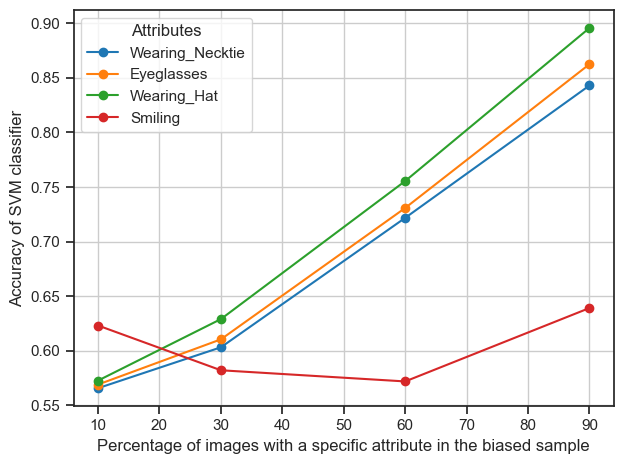

In [75]:
for  i, item in enumerate(accuracy.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Accuracy of SVM classifier")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Accuracy_plot.png")
plt.show()

In [76]:
df = pd.DataFrame(columns = ["attribute", "method", "spearman_correlation", "p-value"])
for  i, item in enumerate(accuracy.items()):
    attr = item[0]
    acc = [accuracy for key, accuracy in item[1].items()]
    was = wasserstein[attr]

    corr_was = scipy.stats.spearmanr(was, [10,30,60,90], alternative="greater")
    corr_acc = scipy.stats.spearmanr(acc, [10,30,60,90], alternative="greater")
    
    df.loc[len(df)] = [attr, "Wasserstein", corr_was[0], corr_was[1] ]
    df.loc[len(df)] = [attr, "SVM", corr_acc[0], corr_acc[1]]

df

,attribute,method,spearman_correlation,p-value
0,Wearing_Necktie,Wasserstein,1.0,0.0
1,Wearing_Necktie,SVM,1.0,0.0
2,Eyeglasses,Wasserstein,1.0,0.0
3,Eyeglasses,SVM,1.0,0.0
4,Wearing_Hat,Wasserstein,1.0,0.0
5,Wearing_Hat,SVM,1.0,0.0
6,Smiling,Wasserstein,0.8,0.1
7,Smiling,SVM,0.2,0.4


In [77]:
print(df.set_index(["attribute"]).to_latex())

\begin{tabular}{llrr}
\toprule
{} &       method &  spearman\_correlation &  p-value \\
attribute       &              &                       &          \\
\midrule
Wearing\_Necktie &  Wasserstein &                   1.0 &      0.0 \\
Wearing\_Necktie &          SVM &                   1.0 &      0.0 \\
Eyeglasses      &  Wasserstein &                   1.0 &      0.0 \\
Eyeglasses      &          SVM &                   1.0 &      0.0 \\
Wearing\_Hat     &  Wasserstein &                   1.0 &      0.0 \\
Wearing\_Hat     &          SVM &                   1.0 &      0.0 \\
Smiling         &  Wasserstein &                   0.8 &      0.1 \\
Smiling         &          SVM &                   0.2 &      0.4 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/1648947662.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.set_index(["attribute"]).to_latex())


## Experiment 2

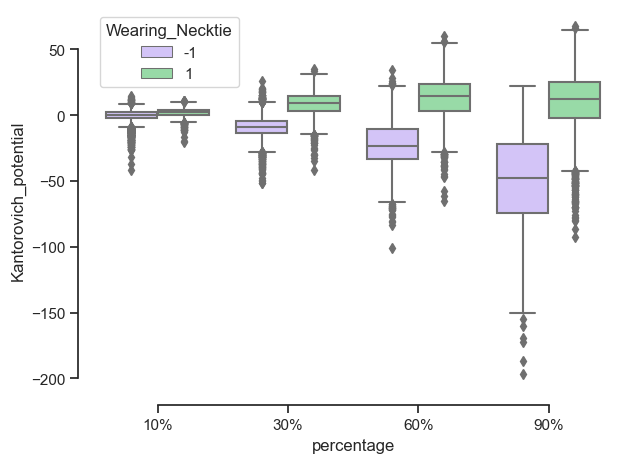

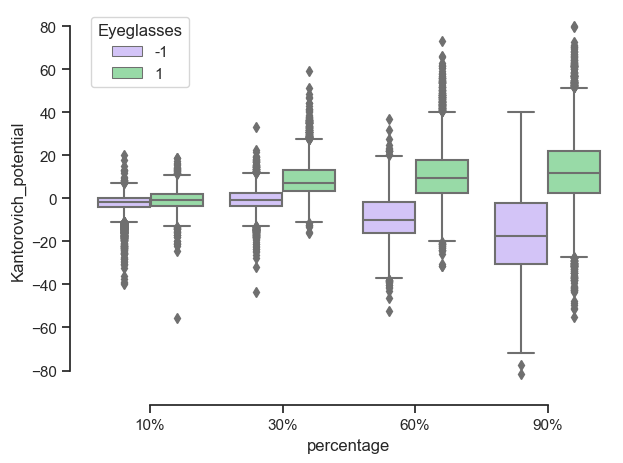

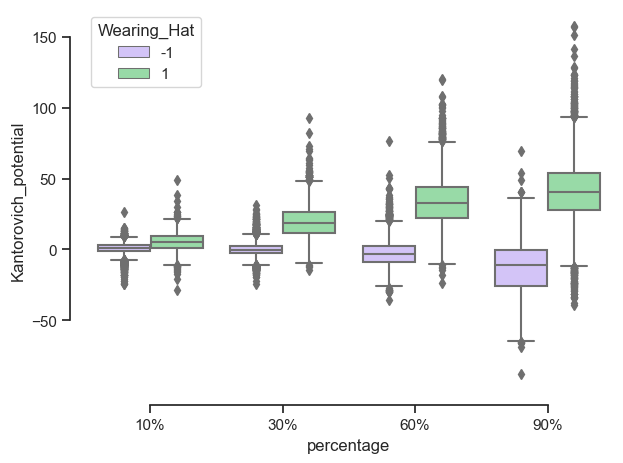

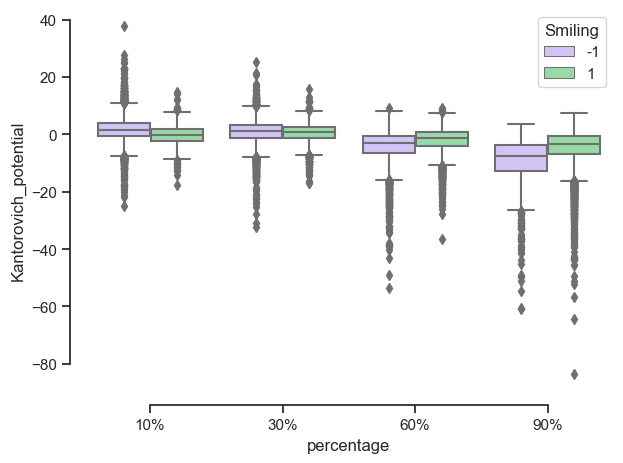

In [78]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        dataframes[attr][i]["percentage"] = "{}%".format(n)

    data = pd.concat(dataframes[attr])

    # Draw a nested boxplot to show bills by day and time
    sns.boxplot(x="percentage", y="Kantorovich_potential",
                hue=attr, palette=["m", "g"],
                data=data)
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig("../results/Experiment1/{0}_Boxplot.png".format(attr, n))
    plt.show()

In [79]:
attributes_list = list()
perc = [10,30,60,90] * 4
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        df = dataframes[attr][i]
        col1 = df[df[attr] == 1].Kantorovich_potential
        col2 = df[df[attr] == -1].Kantorovich_potential
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [80]:
print(table.set_index(["attribute", "percentage"]).to_latex())

\begin{tabular}{llrr}
\toprule
        &    &  statistic &        pvalue \\
attribute & percentage &            &               \\
\midrule
Wearing\_Necktie & 10 &   0.001358 &  9.960244e-01 \\
        & 30 &   0.000000 &  1.000000e+00 \\
        & 60 &   0.000000 &  1.000000e+00 \\
        & 90 &   0.000000 &  1.000000e+00 \\
Eyeglasses & 10 &   0.010123 &  8.407604e-01 \\
        & 30 &   0.000000 &  1.000000e+00 \\
        & 60 &   0.000000 &  1.000000e+00 \\
        & 90 &   0.000000 &  1.000000e+00 \\
Wearing\_Hat & 10 &   0.009259 &  8.644351e-01 \\
        & 30 &   0.000000 &  1.000000e+00 \\
        & 60 &   0.000000 &  1.000000e+00 \\
        & 90 &   0.000000 &  1.000000e+00 \\
Smiling & 10 &   0.221235 &  3.119805e-35 \\
        & 30 &   0.079894 &  3.099225e-11 \\
        & 60 &   0.000093 &  9.998766e-01 \\
        & 90 &   0.000247 &  9.997202e-01 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/2333445097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.set_index(["attribute", "percentage"]).to_latex())


In [81]:
decision_functions["Wearing_Hat"][30]

,index,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,...,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Kantorovich_potential,biased,confidence
5,830,168308,168309.jpg,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,1,18.010925,1,0.315677
6,1218,71741,071742.jpg,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,1,7.322632,1,0.746469
9,5448,81850,081851.jpg,-1,1,1,-1,-1,-1,1,...,-1,-1,-1,1,-1,-1,1,-4.164276,1,0.044278
10,4479,21558,021559.jpg,-1,1,1,-1,-1,-1,1,...,1,1,-1,1,-1,-1,1,-10.706085,1,-0.514039
11,989,112739,112740.jpg,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,2.151489,1,0.344973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17985,651,180758,180759.jpg,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,1,21.842834,1,0.583571
17988,7318,116307,116308.jpg,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,4.164139,1,0.063510
17989,6644,15150,015151.jpg,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-6.593750,1,-0.190664
17991,4212,184033,184034.jpg,-1,1,1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,2.383148,1,-0.124911


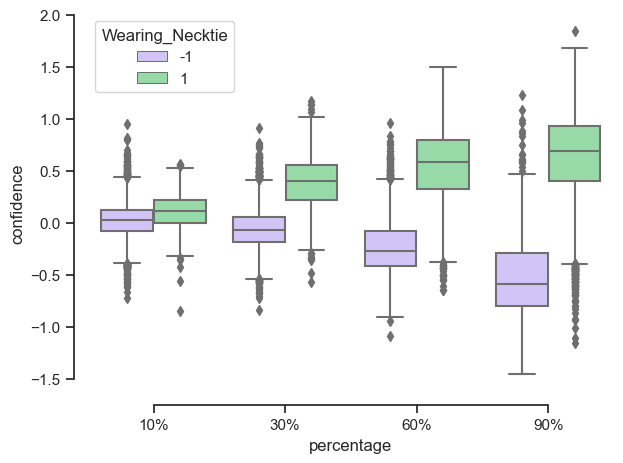

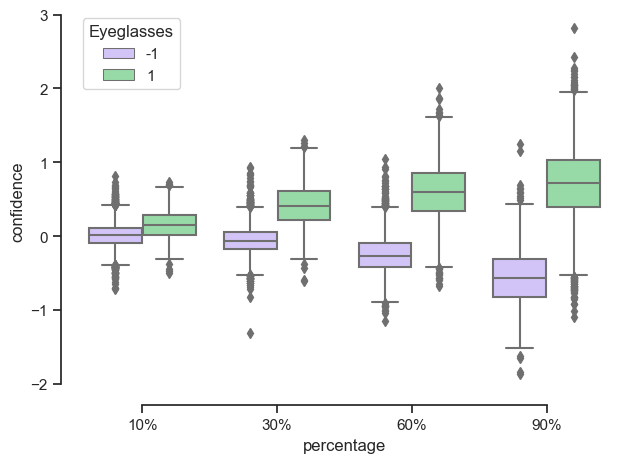

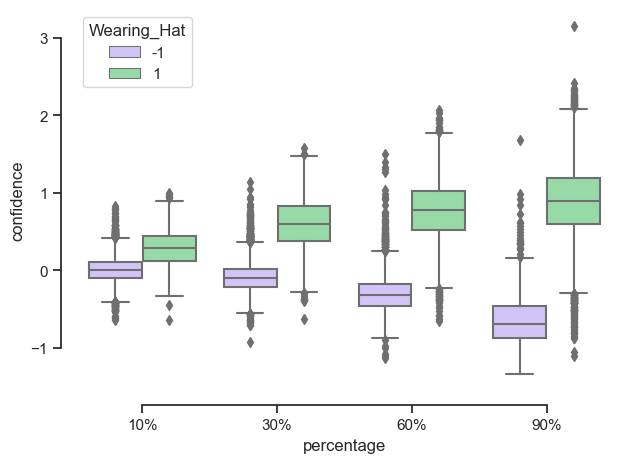

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/3572827447.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_functions[attr][n]["percentage"] = "{}%".format(n)


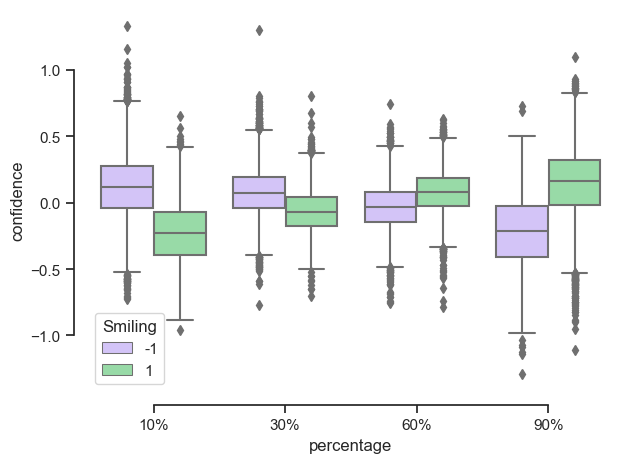

In [82]:
 import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        decision_functions[attr][n]["percentage"] = "{}%".format(n)

    data = pd.concat([d for n,d in decision_functions[attr].items()])

    # Draw a nested boxplot to show bills by day and time
    sns.boxplot(x="percentage", y="confidence",
                hue=attr, palette=["m", "g"],
                data=data)
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig("../results/Experiment1/{0}_confidence_Boxplot.png".format(attr, n))
    plt.show()

In [83]:
attributes_list = list()
perc = [10,30,60,90] * 4
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        n = [10,30,60,90][i]
        df = decision_functions[attr][n]
        col1 = df[df[attr] == 1].confidence
        col2 = df[df[attr] == -1].confidence
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [84]:
print(table.set_index(["attribute", "percentage"]).to_latex())

\begin{tabular}{llrr}
\toprule
        &    &  statistic &         pvalue \\
attribute & percentage &            &                \\
\midrule
Wearing\_Necktie & 10 &   0.002346 &   9.894226e-01 \\
        & 30 &   0.000000 &   1.000000e+00 \\
        & 60 &   0.000000 &   1.000000e+00 \\
        & 90 &   0.000000 &   1.000000e+00 \\
Eyeglasses & 10 &   0.000247 &   9.997202e-01 \\
        & 30 &   0.000000 &   1.000000e+00 \\
        & 60 &   0.000000 &   1.000000e+00 \\
        & 90 &   0.000000 &   1.000000e+00 \\
Wearing\_Hat & 10 &   0.000988 &   9.976981e-01 \\
        & 30 &   0.000000 &   1.000000e+00 \\
        & 60 &   0.000000 &   1.000000e+00 \\
        & 90 &   0.000000 &   1.000000e+00 \\
Smiling & 10 &   0.535679 &  8.755619e-203 \\
        & 30 &   0.336825 &  4.243557e-187 \\
        & 60 &   0.000278 &   9.994076e-01 \\
        & 90 &   0.000000 &   1.000000e+00 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_15956/2333445097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.set_index(["attribute", "percentage"]).to_latex())


## Experiment 3

In [5]:
class NNet_3_layers(nn.Module):
    
    def __init__(self, input_dim = 512):
        super(NNet_3_layers, self).__init__()
        
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(self.input_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(x):
        
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        
        x = F.sigmoid(x)
        
        return x

class NNet_7_layers(nn.Module):
    
    def __init__(self, input_dim = 512):
        super(NNet_3_layers, self).__init__()
        
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(self.input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 1)
        
    def forward(x):
        
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        x = self.fc5(F.relu(x))
        x = self.fc6(F.relu(x))
        x = self.fc7(F.relu(x))
        
        x = F.sigmoid(x)
        
        return x

In [ ]:
def train(model, 
          dataloader,
          epochs,
          criterion,
          lr=0.01):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for epoch in epochs:
        for batch, target in dataloader:
            
            optimizer.zero_grad()
            
            output = model(batch)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()

In [43]:
size = 9000
I = np.identity(2)

# sample from N( (0,0), I)
y_base = np.ones(((size,1)))
base_sample = np.concatenate([np.random.multivariate_normal([0,0], I, size=size), y_base], axis = 1)

acc_tr = {"linear_svm": [],
         "kernel_svm": [],
         "dt_5": [],
         "dt_10": [],
         "dt_20": []}
acc_en = {"linear_svm": [],
         "kernel_svm": [],
         "dt_5": [],
         "dt_10": [],
         "dt_20": []}
for alpha in np.arange(1, 11):
    #sample from N( (alpha, alpha), I)
    y_tr = -np.ones(((size,1)))
    translated_sample = np.concatenate([np.random.multivariate_normal([alpha, alpha], I, size=size), y_tr],
                                       axis = 1)
    
    
    #sample from N(0,0, alpha*I)
    y_en = -np.ones(((size,1)))
    enlarged_sample = np.concatenate([np.random.multivariate_normal([0, 0], alpha*I, size=size), y_en],
                                       axis = 1)
    
    
    
    linear_svm = svm.LinearSVC(max_iter=50000)
    kernel_svm = svm.SVC(max_iter=50000)
    dt_5 = tree.DecisionTreeClassifier(max_depth=5)
    dt_10 = tree.DecisionTreeClassifier(max_depth=10)
    dt_20 = tree.DecisionTreeClassifier(max_depth=20)
    
    training_1 = np.concatenate([base_sample, translated_sample])
    np.random.shuffle(training_1)

    
    linear_svm.fit(training_1[:,:-1], training_1[:,-1])
    kernel_svm.fit(training_1[:,:-1], training_1[:,-1])
    dt_5.fit(training_1[:,:-1], training_1[:,-1])
    dt_10.fit(training_1[:,:-1], training_1[:,-1])
    dt_20.fit(training_1[:,:-1], training_1[:,-1])


    #save accuracies
    acc_tr["linear_svm"].append(linear_svm.score(training_1[:,:-1], training_1[:,-1]))
    acc_tr["kernel_svm"].append(kernel_svm.score(training_1[:,:-1], training_1[:,-1]))
    acc_tr["dt_5"].append(dt_5.score(training_1[:,:-1], training_1[:,-1]))
    acc_tr["dt_10"].append(dt_10.score(training_1[:,:-1], training_1[:,-1]))
    acc_tr["dt_20"].append(dt_20.score(training_1[:,:-1], training_1[:,-1]))

    
    linear_svm = svm.LinearSVC(max_iter=50000)
    kernel_svm = svm.SVC(max_iter=50000)
    dt_5 = tree.DecisionTreeClassifier(max_depth=5)
    dt_10 = tree.DecisionTreeClassifier(max_depth=10)
    dt_20 = tree.DecisionTreeClassifier(max_depth=20)
    
    training_2 = np.concatenate([base_sample, enlarged_sample])
    np.random.shuffle(training_2)

    
    linear_svm.fit(training_2[:,:-1], training_2[:,-1])
    kernel_svm.fit(training_2[:,:-1], training_2[:,-1])
    dt_5.fit(training_2[:,:-1], training_2[:,-1])
    dt_10.fit(training_2[:,:-1], training_2[:,-1])
    dt_20.fit(training_2[:,:-1], training_2[:,-1])
    
    #save accuracies 
    
    acc_en["linear_svm"].append(linear_svm.score(training_1[:,:-1], training_1[:,-1]))
    acc_en["kernel_svm"].append(kernel_svm.score(training_1[:,:-1], training_1[:,-1]))
    acc_en["dt_5"].append(dt_5.score(training_1[:,:-1], training_1[:,-1]))
    acc_en["dt_10"].append(dt_10.score(training_1[:,:-1], training_1[:,-1]))
    acc_en["dt_20"].append(dt_20.score(training_1[:,:-1], training_1[:,-1]))

In [44]:
df_tr = pd.DataFrame(columns = ["method"] + [str(i) for i in range(1,11)] + ["Pearson_corr", "p-value", "Spearman_corr", "p-value"])

quad_was = [.5 * (2 * alpha**2) for alpha in range(1,11)]
pearson, pear_pval = scipy.stats.pearsonr(quad_was, np.arange(1,11))
spear, pval = scipy.stats.spearmanr(quad_was, np.arange(1,11), alternative="greater")
df_tr.loc[0] = ["quadratic_wasserstein"] + quad_was + [pearson, pear_pval, spear, pval]

for key, lst in acc_tr.items():
    pearson, pear_pval = scipy.stats.pearsonr(lst, np.arange(1,11))
    spear, pval = scipy.stats.spearmanr(lst, np.arange(1,11), alternative="greater")
    df_tr.loc[len(df_tr)] = [key] + [round(e, 2) for e in lst] + [pearson, pear_pval, spear, pval]

In [45]:
df_tr

,method,1,2,3,4,5,6,7,8,9,10,Pearson_corr,p-value,Spearman_corr,p-value
0,quadratic_wasserstein,1.00,4.00,9.00,16.0,25.0,36.0,49.0,64.0,81.0,100.0,0.974559,0.000002,1.000000,3.323449e-64
1,linear_svm,0.76,0.92,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.675114,0.032192,0.969223,1.891045e-06
2,kernel_svm,0.77,0.92,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.676148,0.031829,0.969223,1.891045e-06
3,dt_5,0.76,0.92,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.671300,0.033556,0.887625,3.039628e-04
4,dt_10,0.80,0.94,0.99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.645072,0.044010,0.812777,2.129736e-03
5,dt_20,0.94,0.99,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.586234,0.074890,0.812777,2.129736e-03


In [48]:
print(df_tr.to_latex())

\begin{tabular}{llrrrrrrrrrrrrrr}
\toprule
{} &                 method &     1 &     2 &     3 &     4 &     5 &     6 &     7 &     8 &     9 &     10 &  Pearson\_corr &   p-value &  Spearman\_corr &       p-value \\
\midrule
0 &  quadratic\_wasserstein &  1.00 &  4.00 &  9.00 &  16.0 &  25.0 &  36.0 &  49.0 &  64.0 &  81.0 &  100.0 &      0.974559 &  0.000002 &       1.000000 &  3.323449e-64 \\
1 &             linear\_svm &  0.76 &  0.92 &  0.98 &   1.0 &   1.0 &   1.0 &   1.0 &   1.0 &   1.0 &    1.0 &      0.675114 &  0.032192 &       0.969223 &  1.891045e-06 \\
2 &             kernel\_svm &  0.77 &  0.92 &  0.98 &   1.0 &   1.0 &   1.0 &   1.0 &   1.0 &   1.0 &    1.0 &      0.676148 &  0.031829 &       0.969223 &  1.891045e-06 \\
3 &                   dt\_5 &  0.76 &  0.92 &  0.98 &   1.0 &   1.0 &   1.0 &   1.0 &   1.0 &   1.0 &    1.0 &      0.671300 &  0.033556 &       0.887625 &  3.039628e-04 \\
4 &                  dt\_10 &  0.80 &  0.94 &  0.99 &   1.0 &   1.0 &   1.0 &   1

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1109/731903394.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tr.to_latex())


In [46]:
df_en = pd.DataFrame(columns = ["method"] + [str(i) for i in range(1,11)] + ["Pearson_corr", "p-value", "Spearman_corr", "p-value"])

quad_was = [round(1 + alpha - 2*math.sqrt(alpha), 2) for alpha in range(1,11)]
pearson, pear_pval = scipy.stats.pearsonr(quad_was, np.arange(1,11))
spear, pval = scipy.stats.spearmanr(quad_was, np.arange(1,11), alternative="greater")
df_en.loc[0] = ["quadratic_wasserstein"] + quad_was + [pearson, pear_pval, spear, pval]

for key, lst in acc_en.items():
    pearson, pear_pval = scipy.stats.pearsonr(lst, np.arange(1,11))
    spear, pval = scipy.stats.spearmanr(lst, np.arange(1,11), alternative="greater")
    df_en.loc[len(df_en)] = [key] + [round(e, 2) for e in lst] + [pearson, pear_pval, spear, pval]

In [47]:
df_en

,method,1,2,3,4,5,6,7,8,9,10,Pearson_corr,p-value,Spearman_corr,p-value
0,quadratic_wasserstein,0.00,0.17,0.54,1.00,1.53,2.10,2.71,3.34,4.00,4.68,0.991925,1.842206e-08,1.000000,3.323449e-64
1,linear_svm,0.35,0.41,0.74,0.42,0.75,0.75,0.26,0.76,0.25,0.75,0.170565,6.375564e-01,0.163636,3.257387e-01
2,kernel_svm,0.47,0.84,0.91,0.94,0.95,0.96,0.96,0.97,0.97,0.97,0.694360,2.588127e-02,1.000000,3.323449e-64
3,dt_5,0.35,0.80,0.92,0.93,0.95,0.95,0.96,0.96,0.96,0.96,0.664985,3.589984e-02,0.963636,3.660487e-06
4,dt_10,0.38,0.82,0.90,0.94,0.93,0.95,0.96,0.96,0.97,0.97,0.684475,2.900517e-02,0.987879,4.653730e-08
5,dt_20,0.48,0.84,0.95,0.98,0.98,0.99,0.99,0.99,0.99,0.99,0.676339,3.176231e-02,0.963636,3.660487e-06


In [49]:
print(df_en.to_latex())

\begin{tabular}{llrrrrrrrrrrrrrr}
\toprule
{} &                 method &     1 &     2 &     3 &     4 &     5 &     6 &     7 &     8 &     9 &    10 &  Pearson\_corr &       p-value &  Spearman\_corr &       p-value \\
\midrule
0 &  quadratic\_wasserstein &  0.00 &  0.17 &  0.54 &  1.00 &  1.53 &  2.10 &  2.71 &  3.34 &  4.00 &  4.68 &      0.991925 &  1.842206e-08 &       1.000000 &  3.323449e-64 \\
1 &             linear\_svm &  0.35 &  0.41 &  0.74 &  0.42 &  0.75 &  0.75 &  0.26 &  0.76 &  0.25 &  0.75 &      0.170565 &  6.375564e-01 &       0.163636 &  3.257387e-01 \\
2 &             kernel\_svm &  0.47 &  0.84 &  0.91 &  0.94 &  0.95 &  0.96 &  0.96 &  0.97 &  0.97 &  0.97 &      0.694360 &  2.588127e-02 &       1.000000 &  3.323449e-64 \\
3 &                   dt\_5 &  0.35 &  0.80 &  0.92 &  0.93 &  0.95 &  0.95 &  0.96 &  0.96 &  0.96 &  0.96 &      0.664985 &  3.589984e-02 &       0.963636 &  3.660487e-06 \\
4 &                  dt\_10 &  0.38 &  0.82 &  0.90 &  0.94 &  0.9

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1109/2221124288.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_en.to_latex())


In [52]:
size = 9000
I = np.identity(2)

# sample from N( (0,0), I)
y_base = np.ones(((size,1)))
base_sample = np.concatenate([np.random.multivariate_normal([0,0], I, size=size), y_base], axis = 1)

acc_unbalanced = {"linear_svm": [],
         "kernel_svm": [],
         "dt_5": [],
         "dt_10": [],
         "dt_20": []}
acc_balanced_acc = {"linear_svm": [],
         "kernel_svm": [],
         "dt_5": [],
         "dt_10": [],
         "dt_20": []}
for alpha in np.arange(1, 11):
    #sample from N( (10, 10), I)
    y_tr = -np.ones(((alpha*size,1)))
    translated_sample = np.concatenate([np.random.multivariate_normal([1, 1], I, size=alpha*size), y_tr],
                                       axis = 1)
    
    
    
    linear_svm = svm.LinearSVC(max_iter=50000)
    kernel_svm = svm.SVC(max_iter=50000)
    dt_5 = tree.DecisionTreeClassifier(max_depth=5)
    dt_10 = tree.DecisionTreeClassifier(max_depth=10)
    dt_20 = tree.DecisionTreeClassifier(max_depth=20)
    
    training_1 = np.concatenate([base_sample, translated_sample])
    np.random.shuffle(training_1)

    
    linear_svm.fit(training_1[:,:-1], training_1[:,-1])
    kernel_svm.fit(training_1[:,:-1], training_1[:,-1])
    dt_5.fit(training_1[:,:-1], training_1[:,-1])
    dt_10.fit(training_1[:,:-1], training_1[:,-1])
    dt_20.fit(training_1[:,:-1], training_1[:,-1])


    #save accuracies
    acc_unbalanced["linear_svm"].append(linear_svm.score(training_1[:,:-1], training_1[:,-1]))
    acc_unbalanced["kernel_svm"].append(kernel_svm.score(training_1[:,:-1], training_1[:,-1]))
    acc_unbalanced["dt_5"].append(dt_5.score(training_1[:,:-1], training_1[:,-1]))
    acc_unbalanced["dt_10"].append(dt_10.score(training_1[:,:-1], training_1[:,-1]))
    acc_unbalanced["dt_20"].append(dt_20.score(training_1[:,:-1], training_1[:,-1]))
    
    acc_balanced_acc["linear_svm"].append(balanced_accuracy_score(linear_svm.predict(training_1[:,:-1]),
                                                                  training_1[:,-1]))
    acc_balanced_acc["kernel_svm"].append(balanced_accuracy_score(kernel_svm.predict(training_1[:,:-1]),
                                                                  training_1[:,-1]))
    acc_balanced_acc["dt_5"].append(balanced_accuracy_score(dt_5.predict(training_1[:,:-1]),
                                                                  training_1[:,-1]))
    acc_balanced_acc["dt_10"].append(balanced_accuracy_score(dt_10.predict(training_1[:,:-1]),
                                                                  training_1[:,-1]))
    acc_balanced_acc["dt_20"].append(balanced_accuracy_score(dt_20.predict(training_1[:,:-1]),
                                                                  training_1[:,-1]))

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/

In [63]:
df_unbalanced = pd.DataFrame(columns = ["method"] + [str(i) for i in range(1,11)] +\
                             ["Pearson_corr", "p-value", "Spearman_corr", "p-value"])

quad_was = [1]*10
pearson, pear_pval = scipy.stats.pearsonr(quad_was, np.arange(1,11))
spear, pval = scipy.stats.spearmanr(quad_was, np.arange(1,11), alternative="greater")
df_unbalanced.loc[0] = ["quadratic_wasserstein"] + quad_was + [pearson, pear_pval, spear, pval]

for key, lst in acc_unbalanced.items():
    pearson, pear_pval = scipy.stats.pearsonr(lst, np.arange(1,11))
    spear, pval = scipy.stats.spearmanr(lst, np.arange(1,11), alternative="greater")
    df_unbalanced.loc[len(df_unbalanced)] = [key] + [round(e, 2) for e in lst] + [pearson, pear_pval, spear, pval]

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [64]:
df_unbalanced

,method,1,2,3,4,5,6,7,8,9,10,Pearson_corr,p-value,Spearman_corr,p-value
0,quadratic_wasserstein,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN
1,linear_svm,0.76,0.78,0.82,0.84,0.86,0.88,0.89,0.90,0.91,0.91,0.970185,3.335188e-06,1.000000,3.323449e-64
2,kernel_svm,0.76,0.78,0.81,0.84,0.86,0.88,0.89,0.90,0.91,0.92,0.973756,2.010634e-06,1.000000,3.323449e-64
3,dt_5,0.76,0.78,0.81,0.84,0.86,0.88,0.89,0.90,0.91,0.92,0.973308,2.150496e-06,1.000000,3.323449e-64
4,dt_10,0.80,0.81,0.83,0.86,0.87,0.89,0.90,0.91,0.92,0.92,0.978942,8.387624e-07,1.000000,3.323449e-64
5,dt_20,0.93,0.93,0.93,0.94,0.94,0.94,0.95,0.95,0.96,0.96,0.974401,1.821536e-06,0.963636,3.660487e-06


In [65]:
df_balanced_acc = pd.DataFrame(columns = ["method"] + [str(i) for i in range(1,11)] +\
                               ["Pearson_corr", "p-value", "Spearman_corr", "p-value"])

quad_was = [1]*10
pearson, pear_pval = scipy.stats.pearsonr(quad_was, np.arange(1,11))
spear, pval = scipy.stats.spearmanr(quad_was, np.arange(1,11), alternative="greater")
df_balanced_acc.loc[0] = ["quadratic_wasserstein"] + quad_was + [pearson, pear_pval, spear, pval]

for key, lst in acc_balanced_acc.items():
    pearson, pear_pval = scipy.stats.pearsonr(lst, np.arange(1,11))
    spear, pval = scipy.stats.spearmanr(lst, np.arange(1,11), alternative="greater")
    df_balanced_acc.loc[len(df_balanced_acc)] = [key] + [round(e, 2) for e in lst] + [pearson, pear_pval, spear, pval]

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [66]:
df_balanced_acc

,method,1,2,3,4,5,6,7,8,9,10,Pearson_corr,p-value,Spearman_corr,p-value
0,quadratic_wasserstein,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN
1,linear_svm,0.76,0.76,0.77,0.78,0.79,0.81,0.82,0.83,0.85,0.85,0.990326,3.787871e-08,1.000000,3.323449e-64
2,kernel_svm,0.76,0.76,0.77,0.78,0.79,0.80,0.80,0.81,0.81,0.81,0.972861,2.297038e-06,0.987879,4.653730e-08
3,dt_5,0.76,0.76,0.76,0.78,0.77,0.79,0.81,0.80,0.79,0.79,0.815519,4.029542e-03,0.842424,1.110016e-03
4,dt_10,0.80,0.79,0.80,0.81,0.81,0.82,0.82,0.82,0.83,0.84,0.939287,5.522105e-05,0.927273,5.601725e-05
5,dt_20,0.93,0.93,0.93,0.94,0.94,0.94,0.96,0.94,0.96,0.95,0.900878,3.741449e-04,0.878788,4.069311e-04


In [67]:
print(pd.concat([df_unbalanced, df_balanced_acc]).to_latex())

\begin{tabular}{llrrrrrrrrrrrrrr}
\toprule
{} &                 method &     1 &     2 &     3 &     4 &     5 &     6 &     7 &     8 &     9 &    10 &  Pearson\_corr &       p-value &  Spearman\_corr &       p-value \\
\midrule
0 &  quadratic\_wasserstein &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &           NaN &           NaN &            NaN &           NaN \\
1 &             linear\_svm &  0.76 &  0.78 &  0.82 &  0.84 &  0.86 &  0.88 &  0.89 &  0.90 &  0.91 &  0.91 &      0.970185 &  3.335188e-06 &       1.000000 &  3.323449e-64 \\
2 &             kernel\_svm &  0.76 &  0.78 &  0.81 &  0.84 &  0.86 &  0.88 &  0.89 &  0.90 &  0.91 &  0.92 &      0.973756 &  2.010634e-06 &       1.000000 &  3.323449e-64 \\
3 &                   dt\_5 &  0.76 &  0.78 &  0.81 &  0.84 &  0.86 &  0.88 &  0.89 &  0.90 &  0.91 &  0.92 &      0.973308 &  2.150496e-06 &       1.000000 &  3.323449e-64 \\
4 &                  dt\_10 &  0.80 &  0.81 &  0.83 &  0.86 &  0.8

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_1109/3956990925.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([df_unbalanced, df_balanced_acc]).to_latex())


## Experiment 4

In [18]:
# paths 
attributes = ["Wearing_Necktie", "Eyeglasses", "Wearing_Hat", "Smiling"]

celebA_csv = "../data/celeba/list_attr_celeba.csv"
female_csvs = dict()
male_csvs = dict()
dataframes_male = dict()
dataframes_female = dict()
for attr in attributes:
    female_csvs[attr] = "../data/celeba/experiment3_Female_{}.csv".format(attr)
    male_csvs[attr] = ["../data/celeba/experiment3_Male_{}_{}.csv".format(attr, n) for n in [10,30,60,90]]
    dataframes_male[attr] = [pd.read_csv(male_csvs[attr][i]) for i in range(4)]
    dataframes_female[attr] = pd.read_csv("../data/celeba/experiment3_Female_{}.csv".format(attr))

In [19]:
wasserstein_df = pd.read_csv("../results/experiment3_wasserstein.tsv", sep= "\t", header=None)
wasserstein_df.columns = ["X", "Y", "wasserstein"]

wasserstein_df["attr"] = wasserstein_df["X"].apply(lambda x: extract_attribute(x, attributes))

wasserstein = {attr: list(reversed(list(wasserstein_df[wasserstein_df["attr"] == attr].wasserstein)))\
               for attr in attributes}

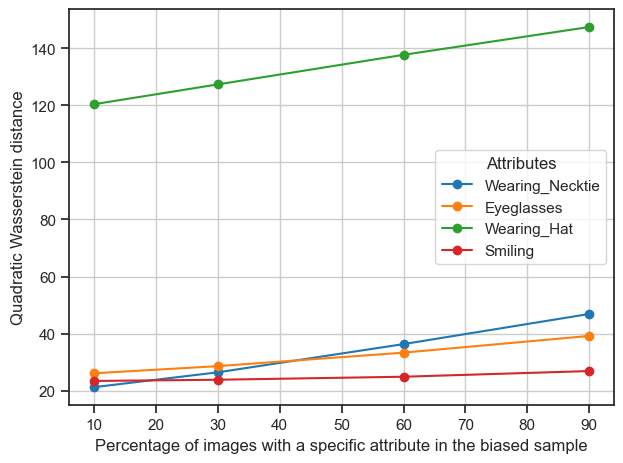

In [20]:
for i, item in enumerate(wasserstein.items()):

    attr, scores = item
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic Wasserstein distance")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment3/Wasserstein_distance_plot.png")
plt.show()

In [21]:
test_df = pd.read_csv("../data/celeba/experiment3_test.csv")
test_df.head()

test_space = list()
test_y = list()
for i in concat.index:
    file = concat.loc[i, "image_id"]
    g = concat.loc[i, "Male"]
    arr = torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()
    test_space.append(arr)
    test_y.append(g)

test_X = np.concatenate(test_space)
test_y = np.array(test_y)

In [30]:
accuracy = dict()
test_fairness = dict()
correlations = dict()
for attr in attributes:
    accuracy[attr] = dict()
    test_fairness[attr] = dict()
    correlations[attr] = dict()
    
    for j in range(4):
        n = [10,30,60,90][j]
        
        
        concat = pd.concat([dataframes_male[attr][j], dataframes_female[attr]])
        # shuffle
        concat = concat.sample(frac=1).reset_index()
        space = list()
        y = list()
        for i in concat.index:
            file = concat.loc[i, "image_id"]
            g = concat.loc[i, "Male"]
            arr = torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()
            space.append(arr)
            y.append(g)

        X = np.concatenate(space)
        y = np.array(y)
        
        classifier = svm.LinearSVC()
        
        classifier.fit(X, y)
        accuracy[attr][n] = classifier.score(X, y)
        
        test_y_hat = classifier.predict(test_X)
        # misclassification rates for the biased sample
        test_fairness[attr][n] = 1 - (test_y_hat[test_y == 1] == 1).sum()/len(test_y_hat[test_y == 1])
        
        df = concat[concat["Male"] == 1]
        correlations[attr][n] = np.corrcoef(classifier.decision_function(X[y == 1]), df["Kantorovich_potential"])[0,1]
        

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.p

In [31]:
test_fairness

{'Wearing_Necktie': {10: 0.06233988044406491,
  30: 0.07657272986051811,
  60: 0.05123825789923142,
  90: 0.15058354682607455},
 'Eyeglasses': {10: 0.06262453743239393,
  30: 0.07828067179049247,
  60: 0.13236549957301447,
  90: 0.27085112439510395},
 'Wearing_Hat': {10: 0.048961001992598896,
  30: 0.06162823797324224,
  60: 0.07970395673213782,
  90: 0.18403074295473953},
 'Smiling': {10: 0.014090520922288685,
  30: 0.07984628522630233,
  60: 0.09308283518360372,
  90: 0.06717904924565898}}

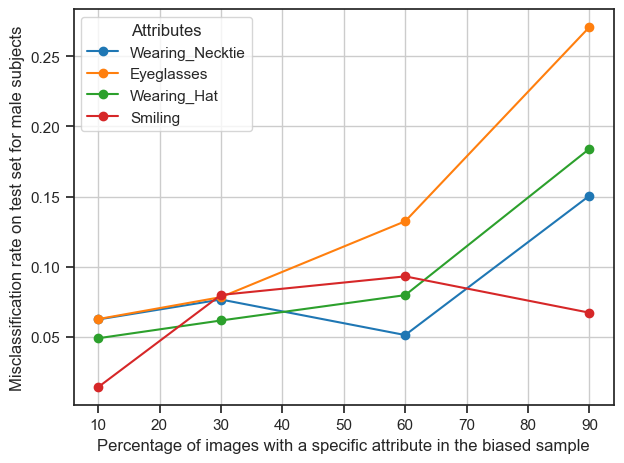

In [32]:
for  i, item in enumerate(test_fairness.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Misclassification rate on test set for male subjects")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment3/Misclassification_plot.png")
plt.show()

In [41]:
df = pd.DataFrame(correlations)
df.index.name = "percentage"

print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Wearing\_Necktie &  Eyeglasses &  Wearing\_Hat &   Smiling \\
percentage &                  &             &              &           \\
\midrule
10         &         0.640576 &    0.672277 &     0.333722 &  0.668893 \\
30         &         0.691179 &    0.656805 &     0.357173 &  0.685716 \\
60         &         0.757694 &    0.669088 &     0.524827 &  0.672014 \\
90         &         0.732541 &    0.650275 &     0.444919 &  0.693960 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_8565/461814051.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [39]:
df

,Wearing_Necktie,Eyeglasses,Wearing_Hat,Smiling
10,0.640576,0.672277,0.333722,0.668893
30,0.691179,0.656805,0.357173,0.685716
60,0.757694,0.669088,0.524827,0.672014
90,0.732541,0.650275,0.444919,0.693960


In [124]:
classifier = svm.LinearSVC()

In [125]:
classifier.fit(space, y)

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [128]:
classifier.score(space, y)

0.9286397322495816

In [87]:
dataframes_female.keys()

dict_keys(['Wearing_Necktie', 'Eyeglasses', 'Wearing_Hat', 'Smiling'])